# GUI Demo and Interactive Testing

This notebook demonstrates how to use the GUI application and provides interactive testing of your trained models.

## Objectives:
- Launch and test the GUI application
- Load and test both baseline and augmented models
- Interactive colorization of user images
- Performance testing and user experience evaluation

In [1]:
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageTk
import yaml
import subprocess
import threading
import time
import warnings
warnings.filterwarnings('ignore')

# Add src to path
sys.path.append('../src')
from model_architecture import create_model
from data_preprocessing import DataPreprocessor
from evaluation import ColorizationEvaluator

print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

# Check if we're in a GUI environment
try:
    import tkinter as tk
    test_root = tk.Tk()
    test_root.withdraw()  # Hide the test window
    test_root.destroy()
    gui_available = True
    print("✅ GUI environment available")
except Exception as e:
    gui_available = False
    print(f"⚠️ GUI environment not available: {e}")
    print("   Running in headless mode - GUI demo will be limited")

Libraries imported successfully!
PyTorch version: 2.8.0+cpu
CUDA available: False
✅ GUI environment available


## 1. Setup and Check Model Availability

In [20]:
# Load configuration
config_path = "../config/config.yaml"
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

# Setup directories
baseline_model_dir = "../models/baseline_model"
augmented_model_dir = "../models/augmented_model"
gui_demo_results = "../results/gui_demo"

os.makedirs(gui_demo_results, exist_ok=True)

print(f"GUI demo results will be saved to: {gui_demo_results}")

# Check for trained models
baseline_model_path = os.path.join(baseline_model_dir, "baseline_model_complete.pth")
augmented_model_path = os.path.join(augmented_model_dir, "augmented_model_complete.pth")
baseline_weights_path = os.path.join(baseline_model_dir, "baseline_weights.pth")
augmented_weights_path = os.path.join(augmented_model_dir, "augmented_weights.pth")

print(f"\nModel Availability Check:")
print(f"=" * 30)

baseline_available = False
augmented_available = False

if os.path.exists(baseline_model_path) or os.path.exists(baseline_weights_path):
    baseline_available = True
    print(f"✅ Baseline model found")
    if os.path.exists(baseline_model_path):
        print(f"   Complete model: {baseline_model_path}")
    if os.path.exists(baseline_weights_path):
        print(f"   Weights only: {baseline_weights_path}")
else:
    print(f"❌ Baseline model not found")
    print(f"   Expected: {baseline_model_path}")
    print(f"   Or: {baseline_weights_path}")

if os.path.exists(augmented_model_path) or os.path.exists(augmented_weights_path):
    augmented_available = True
    print(f"\n✅ Augmented model found")
    if os.path.exists(augmented_model_path):
        print(f"   Complete model: {augmented_model_path}")
    if os.path.exists(augmented_weights_path):
        print(f"   Weights only: {augmented_weights_path}")
else:
    print(f"\n❌ Augmented model not found")
    print(f"   Expected: {augmented_model_path}")
    print(f"   Or: {augmented_weights_path}")

if not baseline_available and not augmented_available:
    print(f"\n⚠️ No trained models found!")
    print(f"Please train models using notebooks 04 and 05 first.")
    print(f"Or check if models are saved in the correct location.")
else:
    print(f"\n🎉 Ready for GUI testing with available models!")

GUI demo results will be saved to: ../results/gui_demo

Model Availability Check:
✅ Baseline model found
   Complete model: ../models/baseline_model\baseline_model_complete.pth
   Weights only: ../models/baseline_model\baseline_weights.pth

✅ Augmented model found
   Complete model: ../models/augmented_model\augmented_model_complete.pth
   Weights only: ../models/augmented_model\augmented_weights.pth

🎉 Ready for GUI testing with available models!


## 2. Test Model Loading (Non-GUI)

In [21]:
# Test loading models programmatically before GUI
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

baseline_model = None
augmented_model = None

# Test baseline model loading
if baseline_available:
    print(f"\nTesting baseline model loading...")
    try:
        baseline_model = create_model(config_path)
        
        # Load weights
        if os.path.exists(baseline_model_path):
            checkpoint = torch.load(baseline_model_path, map_location=device)
            baseline_model.load_state_dict(checkpoint['model_state_dict'])
        else:
            baseline_model.load_state_dict(torch.load(baseline_weights_path, map_location=device))
        
        baseline_model = baseline_model.to(device)
        baseline_model.eval()
        
        print(f"✅ Baseline model loaded successfully")
        print(f"   Parameters: {baseline_model.count_parameters():,}")
        print(f"   Size: {baseline_model.get_model_size():.2f} MB")
        
        # Test inference
        test_input = torch.randn(1, 1, *config['data']['input_size']).to(device)
        with torch.no_grad():
            test_output = baseline_model(test_input)
        print(f"   Test inference: ✅ Output shape {test_output.shape}")
        
    except Exception as e:
        print(f"❌ Error loading baseline model: {e}")
        baseline_model = None

# Test augmented model loading
if augmented_available:
    print(f"\nTesting augmented model loading...")
    try:
        augmented_model = create_model(config_path)
        
        # Load weights
        if os.path.exists(augmented_model_path):
            checkpoint = torch.load(augmented_model_path, map_location=device)
            augmented_model.load_state_dict(checkpoint['model_state_dict'])
        else:
            augmented_model.load_state_dict(torch.load(augmented_weights_path, map_location=device))
        
        augmented_model = augmented_model.to(device)
        augmented_model.eval()
        
        print(f"✅ Augmented model loaded successfully")
        print(f"   Parameters: {augmented_model.count_parameters():,}")
        print(f"   Size: {augmented_model.get_model_size():.2f} MB")
        
        # Test inference
        test_input = torch.randn(1, 1, *config['data']['input_size']).to(device)
        with torch.no_grad():
            test_output = augmented_model(test_input)
        print(f"   Test inference: ✅ Output shape {test_output.shape}")
        
    except Exception as e:
        print(f"❌ Error loading augmented model: {e}")
        augmented_model = None

print(f"\n📊 Model Loading Summary:")
print(f"  Baseline model: {'✅ Loaded' if baseline_model else '❌ Failed'}")
print(f"  Augmented model: {'✅ Loaded' if augmented_model else '❌ Failed'}")

if baseline_model or augmented_model:
    print(f"\n🎯 Ready for interactive testing!")
else:
    print(f"\n⚠️ No models loaded successfully - GUI will have limited functionality")

Using device: cpu

Testing baseline model loading...


INFO:model_architecture:Initialized unet model
INFO:model_architecture:Model created with 31,036,546 trainable parameters
INFO:model_architecture:Model size: 118.44 MB


✅ Baseline model loaded successfully
   Parameters: 31,036,546
   Size: 118.44 MB
   Test inference: ✅ Output shape torch.Size([1, 2, 256, 256])

Testing augmented model loading...


INFO:model_architecture:Initialized unet model
INFO:model_architecture:Model created with 31,036,546 trainable parameters
INFO:model_architecture:Model size: 118.44 MB


✅ Augmented model loaded successfully
   Parameters: 31,036,546
   Size: 118.44 MB
   Test inference: ✅ Output shape torch.Size([1, 2, 256, 256])

📊 Model Loading Summary:
  Baseline model: ✅ Loaded
  Augmented model: ✅ Loaded

🎯 Ready for interactive testing!


## 3. Launch GUI Application

In [23]:
# Launch the GUI application
if gui_available and (baseline_model or augmented_model):
    print("Launching GUI application...")
    print("Note: The GUI will open in a separate window.")
    print("Close this cell or interrupt the kernel to stop the GUI.")
    print("\n" + "="*50)
    print("GUI INSTRUCTIONS:")
    print("1. Click 'Load Image' to select a color image")
    print("2. Select a model from the dropdown menu")
    print("3. Click 'Colorize' to process the image")
    print("4. Click 'Save Result' to save the colorized image")
    print("5. Try different images and compare models!")
    print("="*50)
    
    try:
        # Launch GUI in a separate thread to keep notebook interactive
        def launch_gui():
            try:
                from gui import main
                main()  # This will block until GUI is closed
            except Exception as e:
                print(f"Error launching GUI: {e}")
        
        # Start GUI in background thread
        gui_thread = threading.Thread(target=launch_gui, daemon=True)
        gui_thread.start()
        
        print("\n🖥️ GUI application started!")
        print("If the GUI window doesn't appear, check:")
        print("  - Your display is properly configured")
        print("  - CustomTkinter is installed (pip install customtkinter)")
        print("  - No firewall blocking the application")
        
        # Wait a bit to see if GUI starts successfully
        time.sleep(3)
        
        if gui_thread.is_alive():
            print("\n✅ GUI is running successfully!")
            print("Switch to the GUI window to start colorizing images.")
        else:
            print("\n❌ GUI may have encountered an error.")
            print("Check the output above for error messages.")
    
    except Exception as e:
        print(f"❌ Error launching GUI: {e}")
        print("\nFallback: Try running the GUI from command line:")
        print("python src/gui.py")

elif not gui_available:
    print("⚠️ GUI not available in this environment")
    print("This is common in:")
    print("  - Headless servers")
    print("  - Docker containers without X11 forwarding")
    print("  - Some cloud notebook environments")
    print("\nAlternatives:")
    print("  1. Run locally: python src/gui.py")
    print("  2. Use programmatic testing below")
    print("  3. Set up X11 forwarding if on remote server")

else:
    print("⚠️ No trained models available for GUI testing")
    print("Please train models first using notebooks 04 and 05")

INFO:gui:GUI initialized successfully


Launching GUI application...
Note: The GUI will open in a separate window.
Close this cell or interrupt the kernel to stop the GUI.

GUI INSTRUCTIONS:
1. Click 'Load Image' to select a color image
2. Select a model from the dropdown menu
3. Click 'Colorize' to process the image
4. Click 'Save Result' to save the colorized image
5. Try different images and compare models!

🖥️ GUI application started!
If the GUI window doesn't appear, check:
  - Your display is properly configured
  - CustomTkinter is installed (pip install customtkinter)
  - No firewall blocking the application

✅ GUI is running successfully!
Switch to the GUI window to start colorizing images.


ERROR:gui:[Errno 2] No such file or directory: 'config/config.yaml'
INFO:gui:Loaded image: D:/colorization_task4/dataset_augmentation/data/raw/val/prefessionalportrait.jpg


## 4. Programmatic Testing (Alternative to GUI)

In [6]:
# Programmatic testing for environments without GUI
print("Programmatic Testing of Models")
print("=" * 40)

# Check for test images
test_image_dir = "../data/processed/val"  # Use validation images for testing
test_images = []

if os.path.exists(test_image_dir):
    test_images = [f for f in os.listdir(test_image_dir) 
                  if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    test_images = test_images[:3]  # Limit to first 3 images
    print(f"Found {len(test_images)} test images in {test_image_dir}")
else:
    print(f"No test images found in {test_image_dir}")

if test_images and (baseline_model or augmented_model):
    print(f"\nTesting colorization on sample images...")
    
    try:
        # Initialize preprocessor and evaluator
        preprocessor = DataPreprocessor(config_path)
        evaluator = ColorizationEvaluator(config_path)
        
        results = []
        
        for i, img_filename in enumerate(test_images):
            print(f"\nProcessing image {i+1}: {img_filename}")
            
            # Load and preprocess image
            img_path = os.path.join(test_image_dir, img_filename)
            
            try:
                # Load image
                image = Image.open(img_path).convert('RGB')
                image = image.resize(tuple(config['data']['input_size']), Image.Resampling.LANCZOS)
                
                # Convert to LAB and prepare tensors
                from skimage import color
                image_np = np.array(image)
                lab_image = color.rgb2lab(image_np).astype(np.float32)
                
                # Extract L channel and normalize
                L = lab_image[:, :, 0] / 100.0  # 0-100 -> 0-1
                L = (L - 0.5) / 0.5  # 0-1 -> -1,1
                L_tensor = torch.from_numpy(L).unsqueeze(0).unsqueeze(0).to(device)
                
                # True AB channels for comparison
                AB_true = lab_image[:, :, 1:] / 128.0  # Normalize AB channels
                AB_true = np.transpose(AB_true, (2, 0, 1))  # HWC -> CHW
                AB_true_tensor = torch.from_numpy(AB_true).unsqueeze(0)
                
                result = {
                    'filename': img_filename,
                    'original_rgb': image_np / 255.0,
                    'input_L': (L + 1) / 2  # For display
                }
                
                # Test baseline model
                if baseline_model:
                    with torch.no_grad():
                        AB_pred_baseline = baseline_model(L_tensor).cpu()
                        
                    # Convert back to RGB
                    rgb_baseline = evaluator.lab_to_rgb(L_tensor.cpu(), AB_pred_baseline)[0]
                    
                    # Calculate metrics
                    psnr_baseline = evaluator.calculate_psnr(rgb_baseline, result['original_rgb'])
                    ssim_baseline = evaluator.calculate_ssim(rgb_baseline, result['original_rgb'])
                    
                    result['baseline'] = {
                        'rgb': rgb_baseline,
                        'psnr': psnr_baseline,
                        'ssim': ssim_baseline
                    }
                    
                    print(f"  Baseline - PSNR: {psnr_baseline:.2f} dB, SSIM: {ssim_baseline:.4f}")
                
                # Test augmented model
                if augmented_model:
                    with torch.no_grad():
                        AB_pred_augmented = augmented_model(L_tensor).cpu()
                        
                    # Convert back to RGB
                    rgb_augmented = evaluator.lab_to_rgb(L_tensor.cpu(), AB_pred_augmented)[0]
                    
                    # Calculate metrics
                    psnr_augmented = evaluator.calculate_psnr(rgb_augmented, result['original_rgb'])
                    ssim_augmented = evaluator.calculate_ssim(rgb_augmented, result['original_rgb'])
                    
                    result['augmented'] = {
                        'rgb': rgb_augmented,
                        'psnr': psnr_augmented,
                        'ssim': ssim_augmented
                    }
                    
                    print(f"  Augmented - PSNR: {psnr_augmented:.2f} dB, SSIM: {ssim_augmented:.4f}")
                
                results.append(result)
                
            except Exception as e:
                print(f"  ❌ Error processing {img_filename}: {e}")
        
        print(f"\n✅ Processed {len(results)} images successfully")
        
        # Save results for later use
        import pickle
        results_path = os.path.join(gui_demo_results, 'programmatic_test_results.pkl')
        with open(results_path, 'wb') as f:
            pickle.dump(results, f)
        print(f"Results saved to: {results_path}")
        
    except Exception as e:
        print(f"❌ Error in programmatic testing: {e}")
        results = []

else:
    print("\nProgrammatic testing skipped - no test images or models available")
    results = []

Programmatic Testing of Models
Found 3 test images in ../data/processed/val

Testing colorization on sample images...

Processing image 1: 1.jpg
  Baseline - PSNR: 8.37 dB, SSIM: 0.6338
  Augmented - PSNR: 9.48 dB, SSIM: 0.4522

Processing image 2: 2.jpg
  Baseline - PSNR: 7.33 dB, SSIM: 0.6627
  Augmented - PSNR: 7.93 dB, SSIM: 0.5517

Processing image 3: beach.jpg
  Baseline - PSNR: 7.48 dB, SSIM: 0.5899
  Augmented - PSNR: 7.03 dB, SSIM: 0.3781

✅ Processed 3 images successfully
Results saved to: ../results/gui_demo\programmatic_test_results.pkl


## 5. Visualize Programmatic Test Results

Visualizing programmatic test results...

Visualizing result 1: 1.jpg


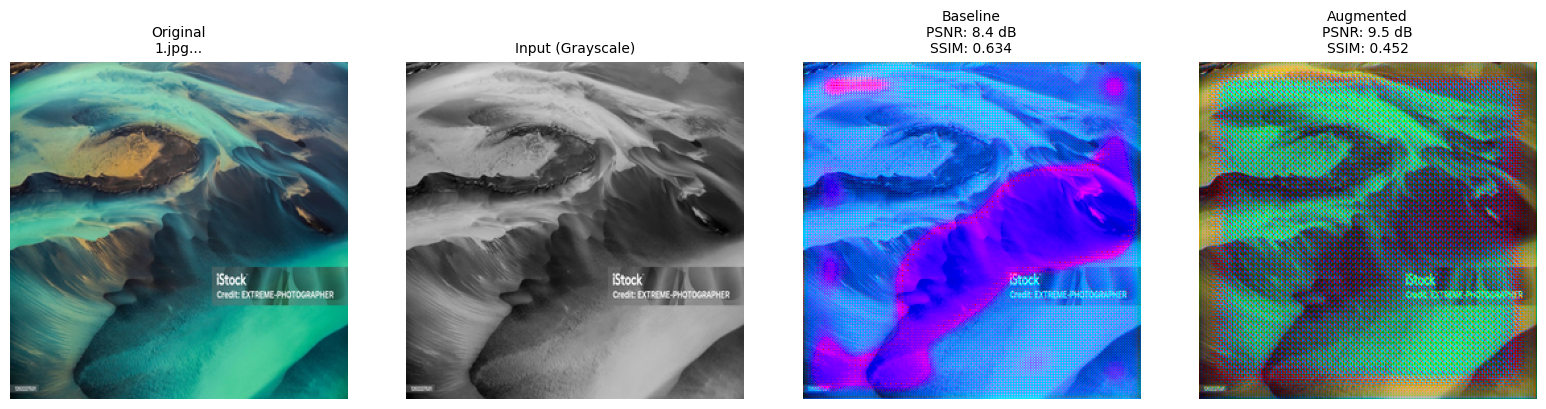

  Saved to: ../results/gui_demo\test_result_1.png
  Model Comparison:
    PSNR improvement: +1.11 dB
    SSIM improvement: -0.1816
    Result: ➖ Mixed results - models performed similarly

Visualizing result 2: 2.jpg


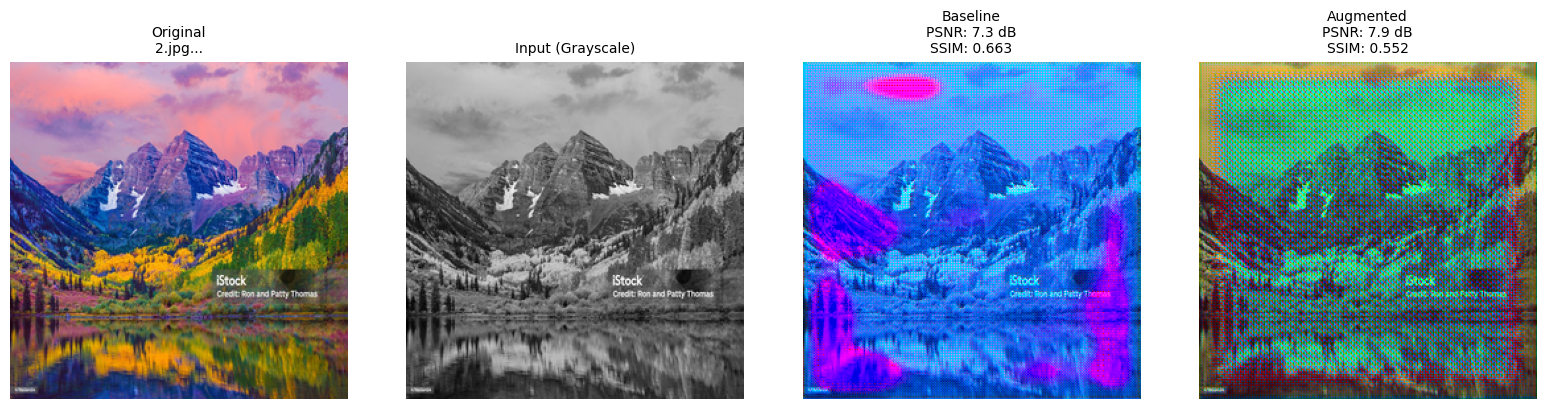

  Saved to: ../results/gui_demo\test_result_2.png
  Model Comparison:
    PSNR improvement: +0.61 dB
    SSIM improvement: -0.1109
    Result: ➖ Mixed results - models performed similarly

Visualizing result 3: beach.jpg


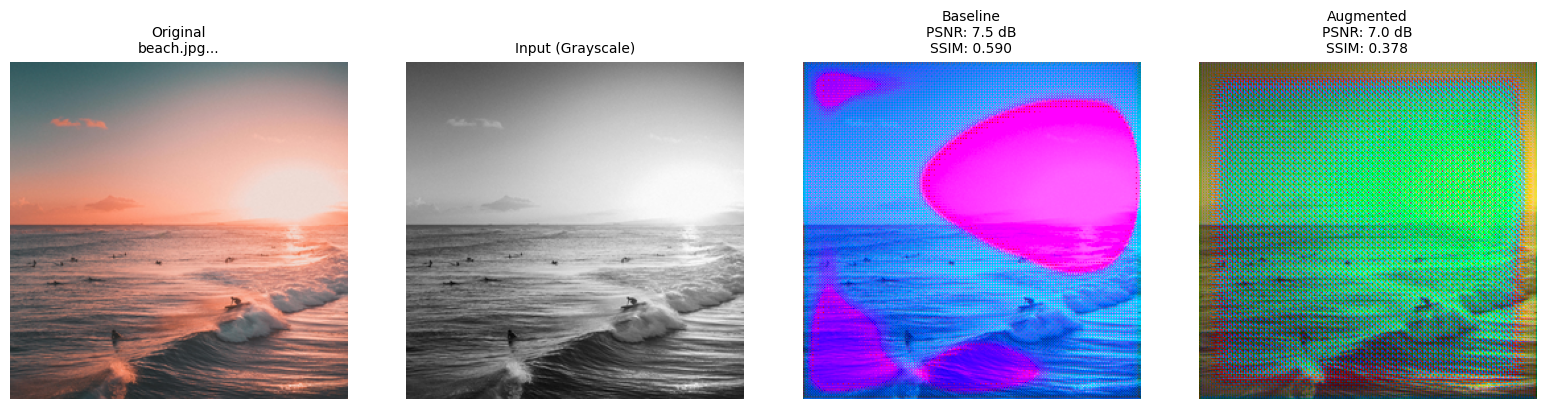

  Saved to: ../results/gui_demo\test_result_3.png
  Model Comparison:
    PSNR improvement: -0.44 dB
    SSIM improvement: -0.2118
    Result: ❌ Baseline model performed better

📊 OVERALL STATISTICS (3 images):
Average PSNR:
  Baseline: 7.73 dB
  Augmented: 8.15 dB
  Improvement: +0.42 dB

Average SSIM:
  Baseline: 0.6288
  Augmented: 0.4607
  Improvement: -0.1681

Model Comparison:
  Augmented wins: 0/3 images
  Win rate: 0.0%
  🏆 Baseline model is competitive


In [7]:
# Visualize results from programmatic testing
if 'results' in locals() and len(results) > 0:
    print("Visualizing programmatic test results...")
    
    for i, result in enumerate(results):
        print(f"\nVisualizing result {i+1}: {result['filename']}")
        
        # Determine how many models we have
        has_baseline = 'baseline' in result
        has_augmented = 'augmented' in result
        
        # Calculate subplot layout
        num_cols = 2 + has_baseline + has_augmented
        fig, axes = plt.subplots(1, num_cols, figsize=(4*num_cols, 4))
        
        if num_cols == 1:
            axes = [axes]
        
        col_idx = 0
        
        # Original image
        axes[col_idx].imshow(result['original_rgb'])
        axes[col_idx].set_title(f'Original\n{result["filename"][:20]}...', fontsize=10)
        axes[col_idx].axis('off')
        col_idx += 1
        
        # Input (grayscale)
        axes[col_idx].imshow(result['input_L'], cmap='gray')
        axes[col_idx].set_title('Input (Grayscale)', fontsize=10)
        axes[col_idx].axis('off')
        col_idx += 1
        
        # Baseline result
        if has_baseline:
            axes[col_idx].imshow(result['baseline']['rgb'])
            axes[col_idx].set_title(
                f'Baseline\nPSNR: {result["baseline"]["psnr"]:.1f} dB\nSSIM: {result["baseline"]["ssim"]:.3f}', 
                fontsize=10
            )
            axes[col_idx].axis('off')
            col_idx += 1
        
        # Augmented result
        if has_augmented:
            axes[col_idx].imshow(result['augmented']['rgb'])
            axes[col_idx].set_title(
                f'Augmented\nPSNR: {result["augmented"]["psnr"]:.1f} dB\nSSIM: {result["augmented"]["ssim"]:.3f}', 
                fontsize=10
            )
            axes[col_idx].axis('off')
            col_idx += 1
        
        plt.tight_layout()
        
        # Save individual result
        result_path = os.path.join(gui_demo_results, f'test_result_{i+1}.png')
        plt.savefig(result_path, dpi=150, bbox_inches='tight')
        plt.show()
        
        print(f"  Saved to: {result_path}")
        
        # Print comparison if both models available
        if has_baseline and has_augmented:
            psnr_diff = result['augmented']['psnr'] - result['baseline']['psnr']
            ssim_diff = result['augmented']['ssim'] - result['baseline']['ssim']
            
            print(f"  Model Comparison:")
            print(f"    PSNR improvement: {psnr_diff:+.2f} dB")
            print(f"    SSIM improvement: {ssim_diff:+.4f}")
            
            if psnr_diff > 0 and ssim_diff > 0:
                print(f"    Result: ✅ Augmented model performed better")
            elif psnr_diff < 0 and ssim_diff < 0:
                print(f"    Result: ❌ Baseline model performed better")
            else:
                print(f"    Result: ➖ Mixed results - models performed similarly")
    
    # Overall statistics
    if len(results) > 1 and has_baseline and has_augmented:
        print(f"\n📊 OVERALL STATISTICS ({len(results)} images):")
        print(f"=" * 50)
        
        baseline_psnrs = [r['baseline']['psnr'] for r in results]
        augmented_psnrs = [r['augmented']['psnr'] for r in results]
        baseline_ssims = [r['baseline']['ssim'] for r in results]
        augmented_ssims = [r['augmented']['ssim'] for r in results]
        
        avg_psnr_baseline = np.mean(baseline_psnrs)
        avg_psnr_augmented = np.mean(augmented_psnrs)
        avg_ssim_baseline = np.mean(baseline_ssims)
        avg_ssim_augmented = np.mean(augmented_ssims)
        
        psnr_improvement = avg_psnr_augmented - avg_psnr_baseline
        ssim_improvement = avg_ssim_augmented - avg_ssim_baseline
        
        print(f"Average PSNR:")
        print(f"  Baseline: {avg_psnr_baseline:.2f} dB")
        print(f"  Augmented: {avg_psnr_augmented:.2f} dB")
        print(f"  Improvement: {psnr_improvement:+.2f} dB")
        
        print(f"\nAverage SSIM:")
        print(f"  Baseline: {avg_ssim_baseline:.4f}")
        print(f"  Augmented: {avg_ssim_augmented:.4f}")
        print(f"  Improvement: {ssim_improvement:+.4f}")
        
        # Count wins
        augmented_wins = sum(1 for r in results 
                           if r['augmented']['psnr'] > r['baseline']['psnr'] 
                           and r['augmented']['ssim'] > r['baseline']['ssim'])
        
        print(f"\nModel Comparison:")
        print(f"  Augmented wins: {augmented_wins}/{len(results)} images")
        print(f"  Win rate: {augmented_wins/len(results)*100:.1f}%")
        
        if augmented_wins > len(results) / 2:
            print(f"  🏆 Augmented model is generally better")
        else:
            print(f"  🏆 Baseline model is competitive")

else:
    print("No programmatic test results to visualize")

## 6. Performance Benchmarking

In [8]:
# Performance benchmarking of the models
if baseline_model or augmented_model:
    print("Performance Benchmarking")
    print("=" * 30)
    
    # Test different batch sizes and input sizes
    

Performance Benchmarking
